## Import libraries

In [30]:
# Written by W.T. Chung, modifirf by Divij Ghose and Thivin Anandh
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import os
#### INSTRUCTIONS FOR I/O (PLEASE READ) #######
# Input data files are available in the read-only "../input/" (relative) or '/kaggle/input'(absolute) directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
input_path = '/home/divij/Projects/2023-flame-ai-challenge/dataset/'
output_path = '/home/divij/Projects/2023-flame-ai-challenge/output/test_16/'

## Set Random Seed

In [26]:
tf.keras.utils.set_random_seed(42)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

## Reading and Plotting Data

In [31]:
#read file ids and file names for train and val data
train_df = pd.read_csv(input_path+'train.csv')
val_df= pd.read_csv(input_path+'val.csv')
#print 5 rows of pandas dataframe
train_df.head()

,id,rho_filename,ux_filename,uy_filename,uz_filename
0,-5634614311666768042,RHO_kgm-3_id-5634614311666768042.dat,UX_ms-1_id-5634614311666768042.dat,UY_ms-1_id-5634614311666768042.dat,UZ_ms-1_id-5634614311666768042.dat
1,-2337253536160728058,RHO_kgm-3_id-2337253536160728058.dat,UX_ms-1_id-2337253536160728058.dat,UY_ms-1_id-2337253536160728058.dat,UZ_ms-1_id-2337253536160728058.dat
2,-7056668419406715714,RHO_kgm-3_id-7056668419406715714.dat,UX_ms-1_id-7056668419406715714.dat,UY_ms-1_id-7056668419406715714.dat,UZ_ms-1_id-7056668419406715714.dat
3,-9138984573931233156,RHO_kgm-3_id-9138984573931233156.dat,UX_ms-1_id-9138984573931233156.dat,UY_ms-1_id-9138984573931233156.dat,UZ_ms-1_id-9138984573931233156.dat
4,2699082921033192879,RHO_kgm-3_id2699082921033192879.dat,UX_ms-1_id2699082921033192879.dat,UY_ms-1_id2699082921033192879.dat,UZ_ms-1_id2699082921033192879.dat


### Plot HR

Text(0.5, 1.0, 'Z-Velocity')

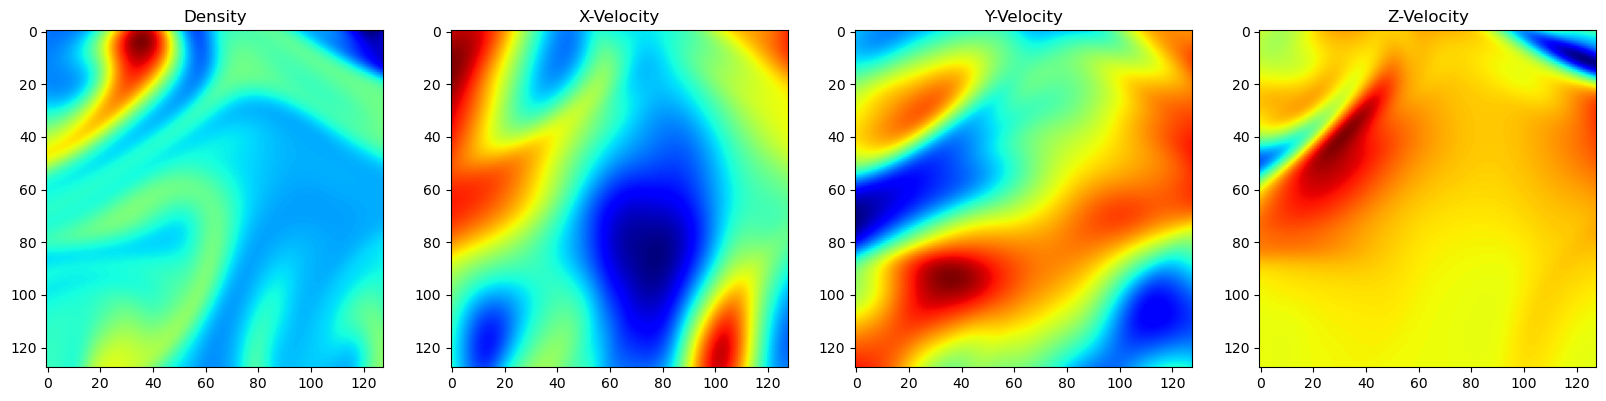

In [32]:
#plot HR labels

idx = 20
data_path = input_path+"flowfields/HR/train"
RHO_filename = train_df['rho_filename'][idx]
UX_filename = train_df['ux_filename'][idx]
UY_filename = train_df['uy_filename'][idx]
UZ_filename = train_df['uz_filename'][idx]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(128, 128), cmap='jet')
axs[0].set_title('Density')
axs[1].imshow(UX.reshape(128, 128), cmap='jet')
axs[1].set_title('X-Velocity')
axs[2].imshow(UY.reshape(128, 128), cmap='jet')
axs[2].set_title('Y-Velocity')
axs[3].imshow(UZ.reshape(128, 128), cmap='jet')
axs[3].set_title('Z-Velocity')

### Plot LR

Text(0.5, 1.0, 'UZ')

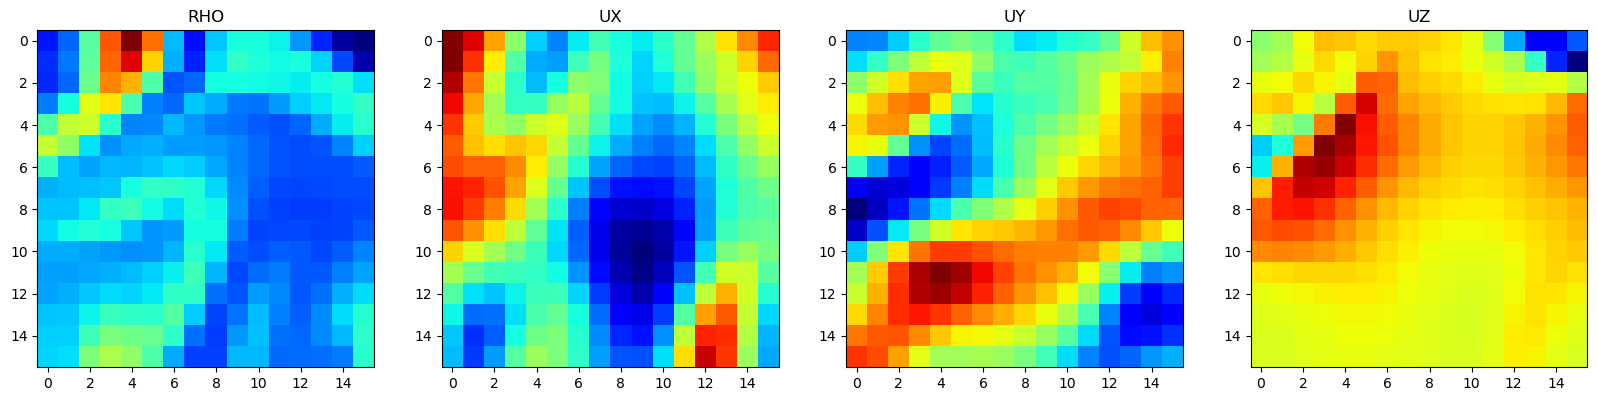

In [5]:
#plot LR features

id = 20
data_path = input_path+"flowfields/LR/train"
RHO_filename = train_df['rho_filename'][id]
UX_filename = train_df['ux_filename'][id]
UY_filename = train_df['uy_filename'][id]
UZ_filename = train_df['uz_filename'][id]
RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4")
UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4")
UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4")
UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(RHO.reshape(16, 16), cmap='jet')
axs[0].set_title('RHO')
axs[1].imshow(UX.reshape(16, 16), cmap='jet')
axs[1].set_title('UX')
axs[2].imshow(UY.reshape(16, 16), cmap='jet')
axs[2].set_title('UY')
axs[3].imshow(UZ.reshape(16, 16), cmap='jet')
axs[3].set_title('UZ')

## Setup Data Pipeline

### Data loader

In [33]:
def getXY(idx,csv_file,mode = "train"):
    LR_path = input_path + "flowfields/LR/" + mode
    HR_path = input_path + "flowfields/HR/" + mode
    #input
    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    #output
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128,128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128,128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128,128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128,128)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    Y = tf.stack([rho_o,ux_o,uy_o,uz_o],axis=2)
    
    return [X,Y]

def getTrainXY(idx):
    return getXY(idx,train_df.reset_index().to_dict(orient='list'),mode = "train")

def getValXY(idx):
    return getXY(idx,val_df.reset_index().to_dict(orient='list'),mode = "val")


### Find mean and standard deviation of train data

In [7]:
nfile = len(train_df)
X_train = []
Y_train = []
for i in range(nfile):
    X_train.append(getTrainXY(i)[0])
    Y_train.append(getTrainXY(i)[1])
X_train = tf.stack(X_train)
Y_train = tf.stack(Y_train)

X_mean = tf.reduce_mean(X_train,axis=0)
X_std = tf.math.reduce_std(X_train,axis=0)
Y_mean = tf.reduce_mean(Y_train,axis=0)
Y_std = tf.math.reduce_std(Y_train,axis=0)
X_mean.shape,X_std.shape,Y_mean.shape,Y_std.shape



2023-09-15 10:32:25.943204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 10:32:25.943426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 10:32:25.961009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 10:32:25.961261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 10:32:25.961440: I tensorflow/compiler/xla/stream_executo

(TensorShape([16, 16, 4]),
 TensorShape([16, 16, 4]),
 TensorShape([128, 128, 4]),
 TensorShape([128, 128, 4]))

### Scale the data prior to training

In [8]:
my_mean = [0.24,28.0, 28.0, 28.0]
my_std = [0.068,48.0, 48.0, 48.0]
my_mean = tf.convert_to_tensor(my_mean, dtype=tf.float32)
my_std = tf.convert_to_tensor(my_std, dtype=tf.float32)

def scale_tf(X,Y,my_mean=my_mean,my_std=my_std):
   
    Xscaled = (X - X_mean)/X_std
    Yscaled = (Y-Y_mean)/Y_std
    # X_scale = X
    # Y_scale = Y
    return (Xscaled,Yscaled)



#wrapper function so tensorflow can understand this
def scale_wrapper(X,Y):
    return tf.py_function(scale_tf, inp=[X,Y], Tout=[tf.float32,tf.float32])

## Make Model

In [34]:
#taken from keras tutorial: https://keras.io/examples/vision/edsr/
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Residual Block
def squeeze_and_excitation(x_in, ratio=8):

    """Performs a squeeze and excitation on a 4D tensor, after convolution"""
    # Squeeze
    x = layers.GlobalAveragePooling2D()(x_in)  
    # Excitation , x.shape[-1] is the number of filters in the convolutional layer
    x = layers.Dense(x_in.shape[-1] // ratio, activation='relu')(x)
    # Self attention
    x = layers.Dense(x_in.shape[-1], activation='sigmoid')(x)
    # Scale output
    x = layers.Multiply()([x_in, x]) 
    return x

def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    # x = layers.Conv2D(64, 3, padding="same")(inputs)
    # x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    # x = squeeze_and_excitation(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x



# def make_model(num_filters=64, num_of_residual_blocks=16):
def make_model(num_filters=64, num_of_residual_blocks=16):

    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 4))
    # Scaling Pixel Values
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    output_layer = layers.Conv2D(4, 3, padding="same")(x)

    return Model(input_layer, output_layer)




## Build Tensorflow data object

In [35]:
def load_train_dataset_wrapper(file_idx):
    return tf.py_function(getTrainXY, inp=[file_idx], Tout=[tf.float32,tf.float32])

def load_val_dataset_wrapper(file_idx):
    return tf.py_function(getValXY, inp=[file_idx], Tout=[tf.float32,tf.float32])

batch_size = 32 #divisible by number of gpus
nfile = len(train_df)

train_ds = tf.data.Dataset.from_tensor_slices(range(nfile))
train_ds = (train_ds
    .shuffle(nfile)
    .map(load_train_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

nfile = len(val_df)
val_ds = tf.data.Dataset.from_tensor_slices(range(nfile))
val_ds = (val_ds
    .map(load_val_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .map(scale_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

## Define custom loss (not used in best performing model)

In [36]:
def grad_x(matrix):
    return np.gradient(matrix,axis = 1)
def grad_y(matrix):
    return np.gradient(matrix,axis = 2)


def grad0(matrix): 
    return np.gradient(matrix)[0]

def grad1(matrix): 
    return np.gradient(matrix,axis=1)

def grad2(matrix): 
    return np.gradient(matrix,axis=2)

def grad3(matrix): 
    return np.gradient(matrix,axis=3)

from tensorflow.keras.utils import get_custom_objects
def pixel_grad_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))
    
    rho_true = y_true[:,:,:,0]
    rho_pred = y_pred[:,:,:,0]
    rho_true_grad_x  = tf.py_function(grad_x,inp=[rho_true],Tout=tf.float32)    
    rho_pred_grad_x  = tf.image.image_gradients(y_pred)[0][:,:,:,0]
    
    u_true = y_true[:,:,:,1]
    u_true_grad_x  = tf.py_function(grad_x,inp=[u_true],Tout=tf.float32)
    u_pred_grad_x  = tf.image.image_gradients(y_pred)[0][:,:,:,1]
    
    v_true = y_true[:,:,:,2]
    v_true_grad_x  = tf.py_function(grad_x,inp=[v_true],Tout=tf.float32)
    v_pred_grad_x  = tf.image.image_gradients(y_pred)[0][:,:,:,2]
    
    w_true = y_true[:,:,:,3]
    w_true_grad_x  = tf.py_function(grad_x,inp=[w_true],Tout=tf.float32)
    w_pred_grad_x  = tf.image.image_gradients(y_pred)[0][:,:,:,3]
    
    rho_true_grad_y  = tf.py_function(grad_y,inp=[rho_true],Tout=tf.float32)    
    rho_pred_grad_y  = tf.image.image_gradients(y_pred)[1][:,:,:,0]
    
    u_true = y_true[:,:,:,1]
    u_true_grad_y  = tf.py_function(grad_y,inp=[u_true],Tout=tf.float32)
    u_pred_grad_y  = tf.image.image_gradients(y_pred)[1][:,:,:,1]
    
    v_true = y_true[:,:,:,2]
    v_true_grad_y  = tf.py_function(grad_y,inp=[v_true],Tout=tf.float32)
    v_pred_grad_y  = tf.image.image_gradients(y_pred)[1][:,:,:,2]
    
    w_true = y_true[:,:,:,3]
    w_true_grad_y  = tf.py_function(grad_y,inp=[w_true],Tout=tf.float32)
    w_pred_grad_y  = tf.image.image_gradients(y_pred)[1][:,:,:,3]
    
    
    # mse_grad_x = tf.reduce_mean(tf.losses.mean_squared_error(rho_true_grad_x, rho_pred_grad_x))
    mse_grad = tf.reduce_mean(
    tf.losses.mean_squared_error(rho_true_grad_x, rho_pred_grad_x) +
    tf.losses.mean_squared_error(u_true_grad_x, u_pred_grad_x) +
    tf.losses.mean_squared_error(v_true_grad_x, v_pred_grad_x) +
    tf.losses.mean_squared_error(w_true_grad_x, w_pred_grad_x) +
    tf.losses.mean_squared_error(rho_true_grad_y, rho_pred_grad_y) +
    tf.losses.mean_squared_error(u_true_grad_y, u_pred_grad_y) +
    tf.losses.mean_squared_error(v_true_grad_y, v_pred_grad_y) +
    tf.losses.mean_squared_error(w_true_grad_y, w_pred_grad_y)
)
    
    # mse_grad_x_p = tf.reduce_sum(rho_pred_grad_x)
    
    
    return 0.1*mse_grad + mse# + tf.losses.mean_squared_error(dy_true, dy_pred)
    
get_custom_objects().update({'pixel_grad_loss': pixel_grad_loss})




## Train Model

In [37]:
#create directories for checkpoints and logs
log_dir = output_path + "logs" 
checkpoint_dir = output_path + "ckpt"
print("log_dir:",log_dir)
print("checkpoint_dir:",checkpoint_dir)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Either restore the latest model, or create a fresh one if there is no checkpoint available.
def make_or_restore_model(alpha=1e-3):
    model =  make_model()
    #set up save/load checkpoints
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    nckpt = 0
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)

        nckpt = int(latest_checkpoint.split('-')[-1])
        restored_model =  tf.keras.models.load_model(latest_checkpoint,custom_objects=get_custom_objects())
        model.set_weights(restored_model.get_weights())
    else:
        print("Creating a new model")
    
    #compile model with optimizerloss functions,metrics
    #NOTE: Although we're only using MSE as the public metric here, we will be also evaluating with SSIM-based metrics to search for best models so you may want to monitor other metrics
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=alpha),
        loss=tf.keras.losses.MeanSquaredError(),
           metrics =[tf.keras.metrics.MeanAbsoluteError()]) #add other metrics here

    return [model,nckpt]


log_dir: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/logs
checkpoint_dir: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt


In [40]:
def run_training(train_dataset=train_ds,val_dataset=val_ds,epochs=100):
    # Create a MirroredStrategy for multi-gpu
    strategy = tf.distribute.MirroredStrategy()
    print('Number of GPUs: {}'.format(strategy.num_replicas_in_sync))
    print("Checkpoint directory: {}".format(checkpoint_dir))
    # For multi-gpu: Open a strategy scope and create/restore the model
    with strategy.scope():
        [model,nckpt] = make_or_restore_model()
    #set up checkpoints and logs
    callbacks = [
        # This callback saves a SavedModel every epoch
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch}", save_freq=220
        ),
        # This callback logs every epoch
        tf.keras.callbacks.CSVLogger(log_dir + "/model_history_log.csv", append=True),

        # LEart rate scheduler
        tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3*0.95**(epoch)))
    ]
    
    #train
    model.fit(
        train_dataset,
        epochs=epochs,
        initial_epoch=nckpt,
        callbacks=callbacks,
        verbose=1,
        validation_data = val_dataset
    )
    
    #save at the end of epoch
    model.save(output_path+'final_model')
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Number of GPUs: 2
Checkpoint directory: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt
Restoring from /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-100
Epoch 101/300


2023-09-15 11:40:42.795112: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1382
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\030TensorSliceDataset:15603"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



43/44 [============================>.] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2739

2023-09-15 11:40:58.785854: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 173
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\030TensorSliceDataset:15609"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



44/44 [==============================] - 18s 160ms/step - loss: 0.2130 - mean_absolute_error: 0.2733 - val_loss: 0.0562 - val_mean_absolute_error: 0.1386 - lr: 0.0010
Epoch 102/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0413 - mean_absolute_error: 0.1131 - val_loss: 0.0439 - val_mean_absolute_error: 0.1163 - lr: 0.0010
Epoch 103/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0328 - mean_absolute_error: 0.0995 - val_loss: 0.0404 - val_mean_absolute_error: 0.1008 - lr: 0.0010
Epoch 104/300
44/44 [==============================] - 6s 138ms/step - loss: 0.0283 - mean_absolute_error: 0.0919 - val_loss: 0.0397 - val_mean_absolute_error: 0.0985 - lr: 0.0010
Epoch 105/300
43/44 [============================>.] - ETA: 0s - loss: 0.0254 - mean_absolute_error: 0.0879

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-105/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-105/assets


44/44 [==============================] - 9s 203ms/step - loss: 0.0254 - mean_absolute_error: 0.0880 - val_loss: 0.0397 - val_mean_absolute_error: 0.0999 - lr: 0.0010
Epoch 106/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0234 - mean_absolute_error: 0.0842 - val_loss: 0.0392 - val_mean_absolute_error: 0.0976 - lr: 0.0010
Epoch 107/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0224 - mean_absolute_error: 0.0839 - val_loss: 0.0403 - val_mean_absolute_error: 0.0970 - lr: 0.0010
Epoch 108/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0216 - mean_absolute_error: 0.0819 - val_loss: 0.0415 - val_mean_absolute_error: 0.1006 - lr: 0.0010
Epoch 109/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0204 - mean_absolute_error: 0.0788 - val_loss: 0.0385 - val_mean_absolute_error: 0.0940 - lr: 0.0010
Epoch 110/300
43/44 [============================>.] - ETA: 0s - loss: 0.0191 - mean_absolute_error: 0.0759

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-110/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-110/assets


44/44 [==============================] - 9s 210ms/step - loss: 0.0193 - mean_absolute_error: 0.0761 - val_loss: 0.0392 - val_mean_absolute_error: 0.0960 - lr: 0.0010
Epoch 111/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0199 - mean_absolute_error: 0.0804 - val_loss: 0.0393 - val_mean_absolute_error: 0.0975 - lr: 0.0010
Epoch 112/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0204 - mean_absolute_error: 0.0825 - val_loss: 0.0404 - val_mean_absolute_error: 0.1006 - lr: 0.0010
Epoch 113/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0192 - mean_absolute_error: 0.0777 - val_loss: 0.0427 - val_mean_absolute_error: 0.1064 - lr: 0.0010
Epoch 114/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0226 - mean_absolute_error: 0.0882 - val_loss: 0.0387 - val_mean_absolute_error: 0.0965 - lr: 0.0010
Epoch 115/300
43/44 [============================>.] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.0798

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-115/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-115/assets


44/44 [==============================] - 9s 195ms/step - loss: 0.0193 - mean_absolute_error: 0.0797 - val_loss: 0.0416 - val_mean_absolute_error: 0.1052 - lr: 0.0010
Epoch 116/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0181 - mean_absolute_error: 0.0761 - val_loss: 0.0381 - val_mean_absolute_error: 0.0942 - lr: 0.0010
Epoch 117/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0178 - mean_absolute_error: 0.0745 - val_loss: 0.0408 - val_mean_absolute_error: 0.0985 - lr: 0.0010
Epoch 118/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0174 - mean_absolute_error: 0.0738 - val_loss: 0.0387 - val_mean_absolute_error: 0.0935 - lr: 0.0010
Epoch 119/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0165 - mean_absolute_error: 0.0718 - val_loss: 0.0390 - val_mean_absolute_error: 0.0969 - lr: 0.0010
Epoch 120/300
43/44 [============================>.] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0732

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-120/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-120/assets


44/44 [==============================] - 9s 212ms/step - loss: 0.0165 - mean_absolute_error: 0.0731 - val_loss: 0.0388 - val_mean_absolute_error: 0.0930 - lr: 0.0010
Epoch 121/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0158 - mean_absolute_error: 0.0701 - val_loss: 0.0398 - val_mean_absolute_error: 0.0969 - lr: 0.0010
Epoch 122/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0179 - mean_absolute_error: 0.0777 - val_loss: 0.0419 - val_mean_absolute_error: 0.1025 - lr: 0.0010
Epoch 123/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0189 - mean_absolute_error: 0.0802 - val_loss: 0.0388 - val_mean_absolute_error: 0.0957 - lr: 0.0010
Epoch 124/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0170 - mean_absolute_error: 0.0751 - val_loss: 0.0390 - val_mean_absolute_error: 0.0958 - lr: 0.0010
Epoch 125/300
43/44 [============================>.] - ETA: 0s - loss: 0.0167 - mean_absolute_error: 0.0776

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-125/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-125/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0167 - mean_absolute_error: 0.0776 - val_loss: 0.0408 - val_mean_absolute_error: 0.1050 - lr: 0.0010
Epoch 126/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0159 - mean_absolute_error: 0.0737 - val_loss: 0.0382 - val_mean_absolute_error: 0.0951 - lr: 0.0010
Epoch 127/300
44/44 [==============================] - 6s 139ms/step - loss: 0.0153 - mean_absolute_error: 0.0705 - val_loss: 0.0417 - val_mean_absolute_error: 0.1015 - lr: 0.0010
Epoch 128/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0214 - mean_absolute_error: 0.0896 - val_loss: 0.0422 - val_mean_absolute_error: 0.1039 - lr: 0.0010
Epoch 129/300
44/44 [==============================] - 6s 137ms/step - loss: 0.0199 - mean_absolute_error: 0.0852 - val_loss: 0.0429 - val_mean_absolute_error: 0.1078 - lr: 0.0010
Epoch 130/300
43/44 [============================>.] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.0757

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-130/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-130/assets


44/44 [==============================] - 9s 199ms/step - loss: 0.0163 - mean_absolute_error: 0.0756 - val_loss: 0.0379 - val_mean_absolute_error: 0.0921 - lr: 0.0010
Epoch 131/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0140 - mean_absolute_error: 0.0672 - val_loss: 0.0374 - val_mean_absolute_error: 0.0916 - lr: 0.0010
Epoch 132/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0135 - mean_absolute_error: 0.0662 - val_loss: 0.0377 - val_mean_absolute_error: 0.0900 - lr: 0.0010
Epoch 133/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0149 - mean_absolute_error: 0.0700 - val_loss: 0.0434 - val_mean_absolute_error: 0.1106 - lr: 0.0010
Epoch 134/300
44/44 [==============================] - 6s 135ms/step - loss: 0.0149 - mean_absolute_error: 0.0709 - val_loss: 0.0391 - val_mean_absolute_error: 0.0974 - lr: 0.0010
Epoch 135/300
43/44 [============================>.] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0669

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-135/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-135/assets


44/44 [==============================] - 9s 217ms/step - loss: 0.0136 - mean_absolute_error: 0.0671 - val_loss: 0.0385 - val_mean_absolute_error: 0.0948 - lr: 0.0010
Epoch 136/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0140 - mean_absolute_error: 0.0684 - val_loss: 0.0400 - val_mean_absolute_error: 0.0992 - lr: 0.0010
Epoch 137/300
44/44 [==============================] - 6s 128ms/step - loss: 0.0139 - mean_absolute_error: 0.0697 - val_loss: 0.0415 - val_mean_absolute_error: 0.1091 - lr: 0.0010
Epoch 138/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0147 - mean_absolute_error: 0.0724 - val_loss: 0.0400 - val_mean_absolute_error: 0.0992 - lr: 0.0010
Epoch 139/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0145 - mean_absolute_error: 0.0724 - val_loss: 0.0391 - val_mean_absolute_error: 0.0958 - lr: 0.0010
Epoch 140/300
43/44 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0706

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-140/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-140/assets


44/44 [==============================] - 9s 198ms/step - loss: 0.0140 - mean_absolute_error: 0.0706 - val_loss: 0.0405 - val_mean_absolute_error: 0.1023 - lr: 0.0010
Epoch 141/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0139 - mean_absolute_error: 0.0710 - val_loss: 0.0392 - val_mean_absolute_error: 0.0972 - lr: 0.0010
Epoch 142/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0198 - mean_absolute_error: 0.0910 - val_loss: 0.0401 - val_mean_absolute_error: 0.0983 - lr: 0.0010
Epoch 143/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0141 - mean_absolute_error: 0.0694 - val_loss: 0.0419 - val_mean_absolute_error: 0.1058 - lr: 0.0010
Epoch 144/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0146 - mean_absolute_error: 0.0727 - val_loss: 0.0393 - val_mean_absolute_error: 0.0993 - lr: 0.0010
Epoch 145/300
43/44 [============================>.] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0674

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-145/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-145/assets


44/44 [==============================] - 9s 213ms/step - loss: 0.0129 - mean_absolute_error: 0.0674 - val_loss: 0.0381 - val_mean_absolute_error: 0.0920 - lr: 0.0010
Epoch 146/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0135 - mean_absolute_error: 0.0685 - val_loss: 0.0385 - val_mean_absolute_error: 0.0944 - lr: 0.0010
Epoch 147/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0131 - mean_absolute_error: 0.0692 - val_loss: 0.0420 - val_mean_absolute_error: 0.1043 - lr: 0.0010
Epoch 148/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0129 - mean_absolute_error: 0.0675 - val_loss: 0.0391 - val_mean_absolute_error: 0.0948 - lr: 0.0010
Epoch 149/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0118 - mean_absolute_error: 0.0636 - val_loss: 0.0379 - val_mean_absolute_error: 0.0937 - lr: 0.0010
Epoch 150/300
43/44 [============================>.] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0635

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-150/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-150/assets


44/44 [==============================] - 9s 196ms/step - loss: 0.0117 - mean_absolute_error: 0.0635 - val_loss: 0.0394 - val_mean_absolute_error: 0.1003 - lr: 0.0010
Epoch 151/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0128 - mean_absolute_error: 0.0698 - val_loss: 0.0402 - val_mean_absolute_error: 0.1045 - lr: 0.0010
Epoch 152/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0134 - mean_absolute_error: 0.0721 - val_loss: 0.0386 - val_mean_absolute_error: 0.0950 - lr: 0.0010
Epoch 153/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0130 - mean_absolute_error: 0.0674 - val_loss: 0.0419 - val_mean_absolute_error: 0.1079 - lr: 0.0010
Epoch 154/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0143 - mean_absolute_error: 0.0737 - val_loss: 0.0381 - val_mean_absolute_error: 0.0926 - lr: 0.0010
Epoch 155/300
43/44 [============================>.] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0668

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-155/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-155/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0124 - mean_absolute_error: 0.0668 - val_loss: 0.0400 - val_mean_absolute_error: 0.1027 - lr: 0.0010
Epoch 156/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0132 - mean_absolute_error: 0.0722 - val_loss: 0.0395 - val_mean_absolute_error: 0.0990 - lr: 0.0010
Epoch 157/300
44/44 [==============================] - 6s 135ms/step - loss: 0.0149 - mean_absolute_error: 0.0759 - val_loss: 0.0429 - val_mean_absolute_error: 0.1092 - lr: 0.0010
Epoch 158/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0137 - mean_absolute_error: 0.0719 - val_loss: 0.0428 - val_mean_absolute_error: 0.1068 - lr: 0.0010
Epoch 159/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0161 - mean_absolute_error: 0.0798 - val_loss: 0.0387 - val_mean_absolute_error: 0.0981 - lr: 0.0010
Epoch 160/300
43/44 [============================>.] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0747

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-160/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-160/assets


44/44 [==============================] - 9s 216ms/step - loss: 0.0138 - mean_absolute_error: 0.0748 - val_loss: 0.0395 - val_mean_absolute_error: 0.0987 - lr: 0.0010
Epoch 161/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0134 - mean_absolute_error: 0.0695 - val_loss: 0.0410 - val_mean_absolute_error: 0.1093 - lr: 0.0010
Epoch 162/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0124 - mean_absolute_error: 0.0693 - val_loss: 0.0401 - val_mean_absolute_error: 0.1051 - lr: 0.0010
Epoch 163/300
44/44 [==============================] - 6s 128ms/step - loss: 0.0127 - mean_absolute_error: 0.0729 - val_loss: 0.0398 - val_mean_absolute_error: 0.0972 - lr: 0.0010
Epoch 164/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0115 - mean_absolute_error: 0.0658 - val_loss: 0.0394 - val_mean_absolute_error: 0.0984 - lr: 0.0010
Epoch 165/300
43/44 [============================>.] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0715

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-165/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-165/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0134 - mean_absolute_error: 0.0716 - val_loss: 0.0406 - val_mean_absolute_error: 0.1052 - lr: 0.0010
Epoch 166/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0137 - mean_absolute_error: 0.0716 - val_loss: 0.0387 - val_mean_absolute_error: 0.0991 - lr: 0.0010
Epoch 167/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0124 - mean_absolute_error: 0.0682 - val_loss: 0.0385 - val_mean_absolute_error: 0.0964 - lr: 0.0010
Epoch 168/300
44/44 [==============================] - 6s 137ms/step - loss: 0.0101 - mean_absolute_error: 0.0594 - val_loss: 0.0381 - val_mean_absolute_error: 0.0960 - lr: 0.0010
Epoch 169/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0105 - mean_absolute_error: 0.0637 - val_loss: 0.0384 - val_mean_absolute_error: 0.0953 - lr: 0.0010
Epoch 170/300
43/44 [============================>.] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.0616

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-170/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-170/assets


44/44 [==============================] - 9s 217ms/step - loss: 0.0100 - mean_absolute_error: 0.0616 - val_loss: 0.0388 - val_mean_absolute_error: 0.0960 - lr: 0.0010
Epoch 171/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0091 - mean_absolute_error: 0.0570 - val_loss: 0.0378 - val_mean_absolute_error: 0.0905 - lr: 0.0010
Epoch 172/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0094 - mean_absolute_error: 0.0584 - val_loss: 0.0434 - val_mean_absolute_error: 0.1073 - lr: 0.0010
Epoch 173/300
44/44 [==============================] - 6s 140ms/step - loss: 0.0123 - mean_absolute_error: 0.0685 - val_loss: 0.0385 - val_mean_absolute_error: 0.0942 - lr: 0.0010
Epoch 174/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0099 - mean_absolute_error: 0.0593 - val_loss: 0.0377 - val_mean_absolute_error: 0.0907 - lr: 0.0010
Epoch 175/300
43/44 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0579

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-175/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-175/assets


44/44 [==============================] - 9s 196ms/step - loss: 0.0094 - mean_absolute_error: 0.0579 - val_loss: 0.0380 - val_mean_absolute_error: 0.0969 - lr: 0.0010
Epoch 176/300
44/44 [==============================] - 6s 135ms/step - loss: 0.0105 - mean_absolute_error: 0.0625 - val_loss: 0.0392 - val_mean_absolute_error: 0.0998 - lr: 0.0010
Epoch 177/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0103 - mean_absolute_error: 0.0630 - val_loss: 0.0406 - val_mean_absolute_error: 0.1008 - lr: 0.0010
Epoch 178/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0103 - mean_absolute_error: 0.0607 - val_loss: 0.0387 - val_mean_absolute_error: 0.0932 - lr: 0.0010
Epoch 179/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0108 - mean_absolute_error: 0.0605 - val_loss: 0.0410 - val_mean_absolute_error: 0.1005 - lr: 0.0010
Epoch 180/300
43/44 [============================>.] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0670

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-180/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-180/assets


44/44 [==============================] - 9s 213ms/step - loss: 0.0128 - mean_absolute_error: 0.0670 - val_loss: 0.0376 - val_mean_absolute_error: 0.1000 - lr: 0.0010
Epoch 181/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0112 - mean_absolute_error: 0.0632 - val_loss: 0.0371 - val_mean_absolute_error: 0.0941 - lr: 0.0010
Epoch 182/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0111 - mean_absolute_error: 0.0651 - val_loss: 0.0370 - val_mean_absolute_error: 0.0911 - lr: 0.0010
Epoch 183/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0097 - mean_absolute_error: 0.0595 - val_loss: 0.0371 - val_mean_absolute_error: 0.0918 - lr: 0.0010
Epoch 184/300
44/44 [==============================] - 6s 128ms/step - loss: 0.0090 - mean_absolute_error: 0.0571 - val_loss: 0.0371 - val_mean_absolute_error: 0.0901 - lr: 0.0010
Epoch 185/300
43/44 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0530

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-185/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-185/assets


44/44 [==============================] - 8s 193ms/step - loss: 0.0081 - mean_absolute_error: 0.0532 - val_loss: 0.0380 - val_mean_absolute_error: 0.0959 - lr: 0.0010
Epoch 186/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0099 - mean_absolute_error: 0.0625 - val_loss: 0.0375 - val_mean_absolute_error: 0.0926 - lr: 0.0010
Epoch 187/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0090 - mean_absolute_error: 0.0583 - val_loss: 0.0372 - val_mean_absolute_error: 0.0913 - lr: 0.0010
Epoch 188/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0084 - mean_absolute_error: 0.0557 - val_loss: 0.0383 - val_mean_absolute_error: 0.0943 - lr: 0.0010
Epoch 189/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0084 - mean_absolute_error: 0.0537 - val_loss: 0.0369 - val_mean_absolute_error: 0.0889 - lr: 0.0010
Epoch 190/300
43/44 [============================>.] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0524

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-190/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-190/assets


44/44 [==============================] - 9s 196ms/step - loss: 0.0081 - mean_absolute_error: 0.0525 - val_loss: 0.0374 - val_mean_absolute_error: 0.0898 - lr: 0.0010
Epoch 191/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0096 - mean_absolute_error: 0.0579 - val_loss: 0.0370 - val_mean_absolute_error: 0.0941 - lr: 0.0010
Epoch 192/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0099 - mean_absolute_error: 0.0612 - val_loss: 0.0374 - val_mean_absolute_error: 0.0942 - lr: 0.0010
Epoch 193/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0101 - mean_absolute_error: 0.0634 - val_loss: 0.0385 - val_mean_absolute_error: 0.0974 - lr: 0.0010
Epoch 194/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0110 - mean_absolute_error: 0.0662 - val_loss: 0.0389 - val_mean_absolute_error: 0.0955 - lr: 0.0010
Epoch 195/300
43/44 [============================>.] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0669

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-195/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-195/assets


44/44 [==============================] - 10s 219ms/step - loss: 0.0111 - mean_absolute_error: 0.0668 - val_loss: 0.0380 - val_mean_absolute_error: 0.0980 - lr: 0.0010
Epoch 196/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0143 - mean_absolute_error: 0.0744 - val_loss: 0.0436 - val_mean_absolute_error: 0.1125 - lr: 0.0010
Epoch 197/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0194 - mean_absolute_error: 0.0903 - val_loss: 0.0395 - val_mean_absolute_error: 0.1031 - lr: 0.0010
Epoch 198/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0132 - mean_absolute_error: 0.0677 - val_loss: 0.0391 - val_mean_absolute_error: 0.1062 - lr: 0.0010
Epoch 199/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0132 - mean_absolute_error: 0.0699 - val_loss: 0.0375 - val_mean_absolute_error: 0.0931 - lr: 0.0010
Epoch 200/300
43/44 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0620

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-200/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-200/assets


44/44 [==============================] - 8s 193ms/step - loss: 0.0106 - mean_absolute_error: 0.0620 - val_loss: 0.0373 - val_mean_absolute_error: 0.0985 - lr: 0.0010
Epoch 201/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0107 - mean_absolute_error: 0.0633 - val_loss: 0.0362 - val_mean_absolute_error: 0.0891 - lr: 0.0010
Epoch 202/300
44/44 [==============================] - 6s 135ms/step - loss: 0.0092 - mean_absolute_error: 0.0558 - val_loss: 0.0366 - val_mean_absolute_error: 0.0924 - lr: 0.0010
Epoch 203/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0083 - mean_absolute_error: 0.0542 - val_loss: 0.0366 - val_mean_absolute_error: 0.0908 - lr: 0.0010
Epoch 204/300
44/44 [==============================] - 6s 137ms/step - loss: 0.0078 - mean_absolute_error: 0.0522 - val_loss: 0.0362 - val_mean_absolute_error: 0.0881 - lr: 0.0010
Epoch 205/300
43/44 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0525

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-205/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-205/assets


44/44 [==============================] - 9s 196ms/step - loss: 0.0080 - mean_absolute_error: 0.0524 - val_loss: 0.0364 - val_mean_absolute_error: 0.0888 - lr: 0.0010
Epoch 206/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0076 - mean_absolute_error: 0.0511 - val_loss: 0.0364 - val_mean_absolute_error: 0.0914 - lr: 0.0010
Epoch 207/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0076 - mean_absolute_error: 0.0518 - val_loss: 0.0360 - val_mean_absolute_error: 0.0880 - lr: 0.0010
Epoch 208/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0073 - mean_absolute_error: 0.0502 - val_loss: 0.0364 - val_mean_absolute_error: 0.0883 - lr: 0.0010
Epoch 209/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0075 - mean_absolute_error: 0.0514 - val_loss: 0.0359 - val_mean_absolute_error: 0.0877 - lr: 0.0010
Epoch 210/300
43/44 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0499

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-210/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-210/assets


44/44 [==============================] - 9s 196ms/step - loss: 0.0070 - mean_absolute_error: 0.0498 - val_loss: 0.0363 - val_mean_absolute_error: 0.0886 - lr: 0.0010
Epoch 211/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0067 - mean_absolute_error: 0.0485 - val_loss: 0.0363 - val_mean_absolute_error: 0.0883 - lr: 0.0010
Epoch 212/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0071 - mean_absolute_error: 0.0509 - val_loss: 0.0362 - val_mean_absolute_error: 0.0883 - lr: 0.0010
Epoch 213/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0069 - mean_absolute_error: 0.0495 - val_loss: 0.0375 - val_mean_absolute_error: 0.0933 - lr: 0.0010
Epoch 214/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0098 - mean_absolute_error: 0.0616 - val_loss: 0.0365 - val_mean_absolute_error: 0.0920 - lr: 0.0010
Epoch 215/300
43/44 [============================>.] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0558

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-215/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-215/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0086 - mean_absolute_error: 0.0558 - val_loss: 0.0379 - val_mean_absolute_error: 0.0933 - lr: 0.0010
Epoch 216/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0084 - mean_absolute_error: 0.0551 - val_loss: 0.0397 - val_mean_absolute_error: 0.1027 - lr: 0.0010
Epoch 217/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0092 - mean_absolute_error: 0.0602 - val_loss: 0.0374 - val_mean_absolute_error: 0.0970 - lr: 0.0010
Epoch 218/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0087 - mean_absolute_error: 0.0582 - val_loss: 0.0377 - val_mean_absolute_error: 0.0994 - lr: 0.0010
Epoch 219/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0083 - mean_absolute_error: 0.0549 - val_loss: 0.0361 - val_mean_absolute_error: 0.0892 - lr: 0.0010
Epoch 220/300
43/44 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0520

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-220/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-220/assets


44/44 [==============================] - 9s 215ms/step - loss: 0.0076 - mean_absolute_error: 0.0520 - val_loss: 0.0360 - val_mean_absolute_error: 0.0888 - lr: 0.0010
Epoch 221/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0084 - mean_absolute_error: 0.0572 - val_loss: 0.0365 - val_mean_absolute_error: 0.0918 - lr: 0.0010
Epoch 222/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0085 - mean_absolute_error: 0.0578 - val_loss: 0.0376 - val_mean_absolute_error: 0.0963 - lr: 0.0010
Epoch 223/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0085 - mean_absolute_error: 0.0581 - val_loss: 0.0391 - val_mean_absolute_error: 0.0979 - lr: 0.0010
Epoch 224/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0084 - mean_absolute_error: 0.0560 - val_loss: 0.0374 - val_mean_absolute_error: 0.0936 - lr: 0.0010
Epoch 225/300
43/44 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0550

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-225/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-225/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0080 - mean_absolute_error: 0.0550 - val_loss: 0.0364 - val_mean_absolute_error: 0.0898 - lr: 0.0010
Epoch 226/300
44/44 [==============================] - 6s 135ms/step - loss: 0.0079 - mean_absolute_error: 0.0530 - val_loss: 0.0359 - val_mean_absolute_error: 0.0891 - lr: 0.0010
Epoch 227/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0080 - mean_absolute_error: 0.0517 - val_loss: 0.0360 - val_mean_absolute_error: 0.0912 - lr: 0.0010
Epoch 228/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0088 - mean_absolute_error: 0.0556 - val_loss: 0.0373 - val_mean_absolute_error: 0.0924 - lr: 0.0010
Epoch 229/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0089 - mean_absolute_error: 0.0568 - val_loss: 0.0390 - val_mean_absolute_error: 0.0967 - lr: 0.0010
Epoch 230/300
43/44 [============================>.] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0556

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-230/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-230/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0084 - mean_absolute_error: 0.0555 - val_loss: 0.0376 - val_mean_absolute_error: 0.0961 - lr: 0.0010
Epoch 231/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0082 - mean_absolute_error: 0.0541 - val_loss: 0.0359 - val_mean_absolute_error: 0.0894 - lr: 0.0010
Epoch 232/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0078 - mean_absolute_error: 0.0527 - val_loss: 0.0387 - val_mean_absolute_error: 0.0988 - lr: 0.0010
Epoch 233/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0090 - mean_absolute_error: 0.0580 - val_loss: 0.0372 - val_mean_absolute_error: 0.0954 - lr: 0.0010
Epoch 234/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0084 - mean_absolute_error: 0.0569 - val_loss: 0.0372 - val_mean_absolute_error: 0.0930 - lr: 0.0010
Epoch 235/300
43/44 [============================>.] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0569

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-235/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-235/assets


44/44 [==============================] - 10s 218ms/step - loss: 0.0083 - mean_absolute_error: 0.0568 - val_loss: 0.0366 - val_mean_absolute_error: 0.0886 - lr: 0.0010
Epoch 236/300
44/44 [==============================] - 6s 135ms/step - loss: 0.0069 - mean_absolute_error: 0.0491 - val_loss: 0.0361 - val_mean_absolute_error: 0.0879 - lr: 0.0010
Epoch 237/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0067 - mean_absolute_error: 0.0499 - val_loss: 0.0357 - val_mean_absolute_error: 0.0872 - lr: 0.0010
Epoch 238/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0062 - mean_absolute_error: 0.0464 - val_loss: 0.0360 - val_mean_absolute_error: 0.0880 - lr: 0.0010
Epoch 239/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0063 - mean_absolute_error: 0.0467 - val_loss: 0.0359 - val_mean_absolute_error: 0.0870 - lr: 0.0010
Epoch 240/300
43/44 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0483

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-240/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-240/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0068 - mean_absolute_error: 0.0485 - val_loss: 0.0363 - val_mean_absolute_error: 0.0901 - lr: 0.0010
Epoch 241/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0111 - mean_absolute_error: 0.0618 - val_loss: 0.0422 - val_mean_absolute_error: 0.1099 - lr: 0.0010
Epoch 242/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0149 - mean_absolute_error: 0.0746 - val_loss: 0.0382 - val_mean_absolute_error: 0.0963 - lr: 0.0010
Epoch 243/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0121 - mean_absolute_error: 0.0663 - val_loss: 0.0405 - val_mean_absolute_error: 0.1120 - lr: 0.0010
Epoch 244/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0129 - mean_absolute_error: 0.0708 - val_loss: 0.0394 - val_mean_absolute_error: 0.1012 - lr: 0.0010
Epoch 245/300
43/44 [============================>.] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0636

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-245/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-245/assets


44/44 [==============================] - 9s 214ms/step - loss: 0.0108 - mean_absolute_error: 0.0637 - val_loss: 0.0375 - val_mean_absolute_error: 0.0934 - lr: 0.0010
Epoch 246/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0102 - mean_absolute_error: 0.0594 - val_loss: 0.0367 - val_mean_absolute_error: 0.0922 - lr: 0.0010
Epoch 247/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0083 - mean_absolute_error: 0.0539 - val_loss: 0.0358 - val_mean_absolute_error: 0.0885 - lr: 0.0010
Epoch 248/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0075 - mean_absolute_error: 0.0531 - val_loss: 0.0358 - val_mean_absolute_error: 0.0900 - lr: 0.0010
Epoch 249/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0073 - mean_absolute_error: 0.0508 - val_loss: 0.0356 - val_mean_absolute_error: 0.0868 - lr: 0.0010
Epoch 250/300
43/44 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0488

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-250/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-250/assets


44/44 [==============================] - 9s 195ms/step - loss: 0.0069 - mean_absolute_error: 0.0487 - val_loss: 0.0354 - val_mean_absolute_error: 0.0863 - lr: 0.0010
Epoch 251/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0071 - mean_absolute_error: 0.0489 - val_loss: 0.0361 - val_mean_absolute_error: 0.0883 - lr: 0.0010
Epoch 252/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0078 - mean_absolute_error: 0.0518 - val_loss: 0.0356 - val_mean_absolute_error: 0.0868 - lr: 0.0010
Epoch 253/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0069 - mean_absolute_error: 0.0485 - val_loss: 0.0353 - val_mean_absolute_error: 0.0871 - lr: 0.0010
Epoch 254/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0072 - mean_absolute_error: 0.0506 - val_loss: 0.0370 - val_mean_absolute_error: 0.0895 - lr: 0.0010
Epoch 255/300
43/44 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0499

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-255/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-255/assets


44/44 [==============================] - 8s 194ms/step - loss: 0.0071 - mean_absolute_error: 0.0499 - val_loss: 0.0357 - val_mean_absolute_error: 0.0891 - lr: 0.0010
Epoch 256/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0082 - mean_absolute_error: 0.0552 - val_loss: 0.0350 - val_mean_absolute_error: 0.0880 - lr: 0.0010
Epoch 257/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0071 - mean_absolute_error: 0.0509 - val_loss: 0.0363 - val_mean_absolute_error: 0.0899 - lr: 0.0010
Epoch 258/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0072 - mean_absolute_error: 0.0525 - val_loss: 0.0358 - val_mean_absolute_error: 0.0916 - lr: 0.0010
Epoch 259/300
44/44 [==============================] - 6s 128ms/step - loss: 0.0082 - mean_absolute_error: 0.0584 - val_loss: 0.0399 - val_mean_absolute_error: 0.0998 - lr: 0.0010
Epoch 260/300
43/44 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0553

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-260/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-260/assets


44/44 [==============================] - 9s 214ms/step - loss: 0.0079 - mean_absolute_error: 0.0554 - val_loss: 0.0358 - val_mean_absolute_error: 0.0887 - lr: 0.0010
Epoch 261/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0074 - mean_absolute_error: 0.0513 - val_loss: 0.0364 - val_mean_absolute_error: 0.0899 - lr: 0.0010
Epoch 262/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0081 - mean_absolute_error: 0.0529 - val_loss: 0.0378 - val_mean_absolute_error: 0.0939 - lr: 0.0010
Epoch 263/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0100 - mean_absolute_error: 0.0611 - val_loss: 0.0376 - val_mean_absolute_error: 0.0934 - lr: 0.0010
Epoch 264/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0112 - mean_absolute_error: 0.0631 - val_loss: 0.0370 - val_mean_absolute_error: 0.0952 - lr: 0.0010
Epoch 265/300
43/44 [============================>.] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0550

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-265/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-265/assets


44/44 [==============================] - 8s 193ms/step - loss: 0.0085 - mean_absolute_error: 0.0550 - val_loss: 0.0367 - val_mean_absolute_error: 0.0916 - lr: 0.0010
Epoch 266/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0078 - mean_absolute_error: 0.0523 - val_loss: 0.0359 - val_mean_absolute_error: 0.0880 - lr: 0.0010
Epoch 267/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0069 - mean_absolute_error: 0.0489 - val_loss: 0.0352 - val_mean_absolute_error: 0.0880 - lr: 0.0010
Epoch 268/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0061 - mean_absolute_error: 0.0464 - val_loss: 0.0351 - val_mean_absolute_error: 0.0874 - lr: 0.0010
Epoch 269/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0060 - mean_absolute_error: 0.0460 - val_loss: 0.0349 - val_mean_absolute_error: 0.0862 - lr: 0.0010
Epoch 270/300
43/44 [============================>.] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0449

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-270/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-270/assets


44/44 [==============================] - 9s 213ms/step - loss: 0.0058 - mean_absolute_error: 0.0449 - val_loss: 0.0350 - val_mean_absolute_error: 0.0861 - lr: 0.0010
Epoch 271/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0056 - mean_absolute_error: 0.0447 - val_loss: 0.0402 - val_mean_absolute_error: 0.1142 - lr: 0.0010
Epoch 272/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0081 - mean_absolute_error: 0.0577 - val_loss: 0.0361 - val_mean_absolute_error: 0.0896 - lr: 0.0010
Epoch 273/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0065 - mean_absolute_error: 0.0481 - val_loss: 0.0352 - val_mean_absolute_error: 0.0863 - lr: 0.0010
Epoch 274/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0063 - mean_absolute_error: 0.0467 - val_loss: 0.0356 - val_mean_absolute_error: 0.0899 - lr: 0.0010
Epoch 275/300
43/44 [============================>.] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0466

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-275/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-275/assets


44/44 [==============================] - 9s 195ms/step - loss: 0.0062 - mean_absolute_error: 0.0467 - val_loss: 0.0361 - val_mean_absolute_error: 0.0892 - lr: 0.0010
Epoch 276/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0067 - mean_absolute_error: 0.0487 - val_loss: 0.0355 - val_mean_absolute_error: 0.0876 - lr: 0.0010
Epoch 277/300
44/44 [==============================] - 6s 134ms/step - loss: 0.0066 - mean_absolute_error: 0.0482 - val_loss: 0.0369 - val_mean_absolute_error: 0.0915 - lr: 0.0010
Epoch 278/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0091 - mean_absolute_error: 0.0568 - val_loss: 0.0369 - val_mean_absolute_error: 0.0967 - lr: 0.0010
Epoch 279/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0089 - mean_absolute_error: 0.0574 - val_loss: 0.0370 - val_mean_absolute_error: 0.0948 - lr: 0.0010
Epoch 280/300
43/44 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0590

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-280/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-280/assets


44/44 [==============================] - 8s 193ms/step - loss: 0.0091 - mean_absolute_error: 0.0589 - val_loss: 0.0360 - val_mean_absolute_error: 0.0901 - lr: 0.0010
Epoch 281/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0081 - mean_absolute_error: 0.0556 - val_loss: 0.0354 - val_mean_absolute_error: 0.0874 - lr: 0.0010
Epoch 282/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0078 - mean_absolute_error: 0.0525 - val_loss: 0.0360 - val_mean_absolute_error: 0.0901 - lr: 0.0010
Epoch 283/300
44/44 [==============================] - 6s 128ms/step - loss: 0.0073 - mean_absolute_error: 0.0509 - val_loss: 0.0350 - val_mean_absolute_error: 0.0866 - lr: 0.0010
Epoch 284/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0067 - mean_absolute_error: 0.0482 - val_loss: 0.0358 - val_mean_absolute_error: 0.0878 - lr: 0.0010
Epoch 285/300
43/44 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0469

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-285/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-285/assets


44/44 [==============================] - 10s 225ms/step - loss: 0.0063 - mean_absolute_error: 0.0469 - val_loss: 0.0348 - val_mean_absolute_error: 0.0859 - lr: 0.0010
Epoch 286/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0062 - mean_absolute_error: 0.0468 - val_loss: 0.0352 - val_mean_absolute_error: 0.0895 - lr: 0.0010
Epoch 287/300
44/44 [==============================] - 6s 129ms/step - loss: 0.0065 - mean_absolute_error: 0.0496 - val_loss: 0.0353 - val_mean_absolute_error: 0.0867 - lr: 0.0010
Epoch 288/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0057 - mean_absolute_error: 0.0450 - val_loss: 0.0348 - val_mean_absolute_error: 0.0856 - lr: 0.0010
Epoch 289/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0059 - mean_absolute_error: 0.0468 - val_loss: 0.0354 - val_mean_absolute_error: 0.0889 - lr: 0.0010
Epoch 290/300
43/44 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0494

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-290/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-290/assets


44/44 [==============================] - 9s 198ms/step - loss: 0.0068 - mean_absolute_error: 0.0493 - val_loss: 0.0361 - val_mean_absolute_error: 0.0879 - lr: 0.0010
Epoch 291/300
44/44 [==============================] - 6s 131ms/step - loss: 0.0065 - mean_absolute_error: 0.0478 - val_loss: 0.0355 - val_mean_absolute_error: 0.0866 - lr: 0.0010
Epoch 292/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0062 - mean_absolute_error: 0.0464 - val_loss: 0.0357 - val_mean_absolute_error: 0.0878 - lr: 0.0010
Epoch 293/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0078 - mean_absolute_error: 0.0526 - val_loss: 0.0385 - val_mean_absolute_error: 0.0981 - lr: 0.0010
Epoch 294/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0092 - mean_absolute_error: 0.0593 - val_loss: 0.0372 - val_mean_absolute_error: 0.0923 - lr: 0.0010
Epoch 295/300
43/44 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0589

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-295/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-295/assets


44/44 [==============================] - 8s 193ms/step - loss: 0.0093 - mean_absolute_error: 0.0590 - val_loss: 0.0365 - val_mean_absolute_error: 0.0910 - lr: 0.0010
Epoch 296/300
44/44 [==============================] - 6s 130ms/step - loss: 0.0091 - mean_absolute_error: 0.0577 - val_loss: 0.0363 - val_mean_absolute_error: 0.0940 - lr: 0.0010
Epoch 297/300
44/44 [==============================] - 6s 136ms/step - loss: 0.0110 - mean_absolute_error: 0.0643 - val_loss: 0.0378 - val_mean_absolute_error: 0.0981 - lr: 0.0010
Epoch 298/300
44/44 [==============================] - 6s 132ms/step - loss: 0.0108 - mean_absolute_error: 0.0653 - val_loss: 0.0365 - val_mean_absolute_error: 0.0968 - lr: 0.0010
Epoch 299/300
44/44 [==============================] - 6s 133ms/step - loss: 0.0086 - mean_absolute_error: 0.0564 - val_loss: 0.0351 - val_mean_absolute_error: 0.0893 - lr: 0.0010
Epoch 300/300
43/44 [============================>.] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0542

INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-300/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/ckpt/ckpt-300/assets


44/44 [==============================] - 9s 218ms/step - loss: 0.0083 - mean_absolute_error: 0.0542 - val_loss: 0.0353 - val_mean_absolute_error: 0.0896 - lr: 0.0010


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/final_model/assets


INFO:tensorflow:Assets written to: /home/divij/Projects/2023-flame-ai-challenge/output/test_16/final_model/assets


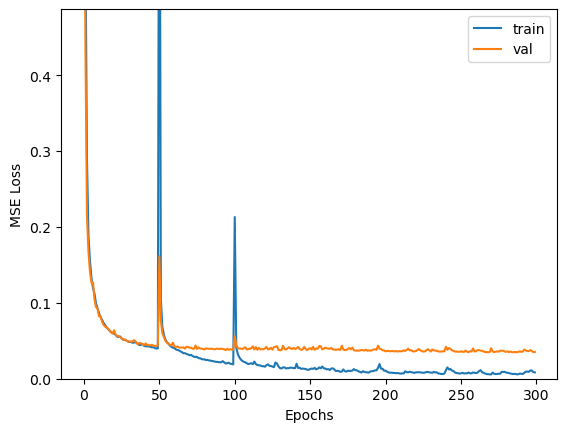

In [42]:
run_training(epochs=300)
metrics = pd.read_csv(output_path+'logs/model_history_log.csv')
metrics
plt.plot(metrics['loss'],label='train')
plt.plot(metrics['val_loss'],label='val')
plt.ylim([0,0.487163])
plt.ylabel("MSE Loss")
plt.xlabel("Epochs")
plt.legend()

In [18]:
#gets test set input
def getTestX(idx):
    csv_file = test_df.reset_index().to_dict(orient='list')
    LR_path = input_path+"flowfields/LR/test" 
    id = csv_file['id'][idx]

    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    
    X = tf.stack([rho_i,ux_i,uy_i,uz_i],axis=2)
    return id,X

#predicts with input
def predict(idx,model):
    id,X = getTestX(idx)
    X = tf.expand_dims(X,0)
    # scale X 
    X = (X-X_mean)/X_std
    y_pred = model.predict(X)
    #added this to rescale predictions CHANGE THIS IF YOU USED DIFFERENT SCALING
    y_pred_unscaled = (y_pred*Y_std)+Y_mean
    return id,y_pred_unscaled

#generates submission with model predictions already in SI units
def generate_submission(model):
    my_mean = [0.24,28.0, 28.0, 28.0]
    my_std = [0.068,48.0, 48.0, 48.0]
    my_mean = np.array(my_mean)
    my_std = np.array(my_std)
    y_preds = {}
    ids = []
    for idx in range(len(test_df)):
        id,y_pred = predict(idx,model) 
        #WARNING tmp should be in SI units
        tmp = (np.array(y_pred) - my_mean)/my_std #this normalizes density and velocity to be in the same range
        y_preds[id]= np.array(tmp).flatten(order='C').astype(np.float32)
        ids.append(id)
    df = pd.DataFrame.from_dict(y_preds,orient='index')
    df['id'] = ids
    #move id to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    #reset index
    df = df.reset_index(drop=True)

    return df

In [19]:
test_df = pd.read_csv(input_path+'/test.csv')
model,_ = make_or_restore_model()
submission_df = generate_submission(model)

Restoring from /home/divij/Projects/2023-flame-ai-challenge/output/test_15/ckpt/ckpt-325
1/1 [==============================] - 0s 19ms/step


In [20]:
submission_df.to_csv(output_path+'submission.csv',index=False)
submission_df.head()

,id,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-657116647631363807,0.931253,0.934954,-0.546241,-0.578827,0.934128,0.934216,-0.545867,-0.577166,0.939143,...,-0.606587,-0.602494,0.939119,0.912866,-0.606033,-0.599511,0.936636,0.914782,-0.604734,-0.596094
1,7483162365939134796,0.924374,0.732165,-0.589589,-0.589862,0.927692,0.740108,-0.586943,-0.590521,0.934352,...,-0.372494,-0.622175,1.015598,0.336542,-0.357368,-0.632375,1.014619,0.336841,-0.345766,-0.636418
2,-6212758420087317096,0.941423,0.670451,-0.588546,-0.580749,0.943631,0.669087,-0.587652,-0.579646,0.947785,...,-0.586753,-0.570684,0.947920,0.885158,-0.587261,-0.568914,0.944981,0.878091,-0.587121,-0.566702
3,-1825935182480952214,-0.821113,1.283190,-0.591930,-1.128531,-0.818982,1.253313,-0.584678,-1.113662,-0.817518,...,-0.838217,-1.254565,-0.966933,1.991360,-0.873553,-1.275455,-0.969254,1.991123,-0.897675,-1.285117
4,-1859240836295259171,2.443699,-0.512410,-0.561092,-0.585751,2.447462,-0.517567,-0.564850,-0.584214,2.455973,...,-0.343188,-0.731559,0.907441,-0.283833,-0.342905,-0.730808,0.892374,-0.280424,-0.344358,-0.729929
